Filename: LRD/ceers-ddt-v2_prism-clear_2750_1034.spec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU    289   435R x 3C   [D, D, D]   
  2  SCI           1 ImageHDU       279   (435, 31)   float64   
  3  WHT           1 ImageHDU       279   (435, 31)   float64   
  4  PROFILE       1 ImageHDU       279   (435, 31)   float64   
  5  PROF1D        1 BinTableHDU     25   31R x 3C   [D, D, D]   
None
Filename: LRD/jades-gdn-v2_prism-clear_1181_68797.spec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU    304   435R x 4C   [D, D, D, D]   
  2  SCI           1 ImageHDU       291   (435, 31)   float64   
  3  WHT           1 ImageHDU       291   (435, 31)   float64   
  4  PROFILE       1 ImageHDU       291   (435, 31)   float64   
  5  PROF1D        1 BinTableHDU     25   31R x 3C   [D, 

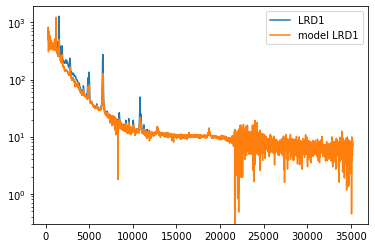

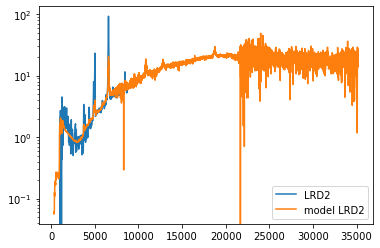

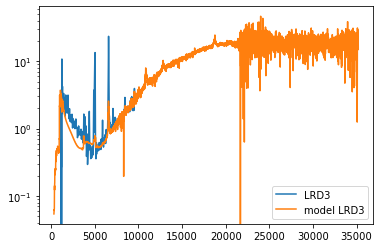

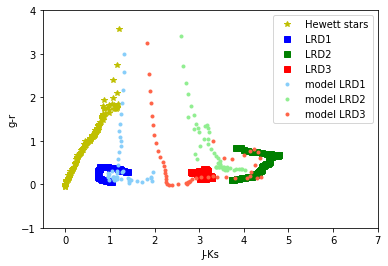

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spectres import spectres
import scipy.integrate as spi
from astropy.io import fits

def LYMAN_BLANKET(lambd, z):
    #Based on Madau https://articles.adsabs.harvard.edu/pdf/1995ApJ...441...18M
    import numpy as np
    nl = 8
    p = 3.46
    npts = len(lambd)
    y = np.zeros((npts, nl), dtype=float)
    lyman = 1. - 1/(np.arange(nl) + 2)**2
    a = np.array([-0.00360, -0.00170, -0.00120, -0.00093,
                  -0.00090, -0.00087, -0.00085, -0.00080])

    c = 0.
    for i in range(nl):
        c += a[i] * ((1+z) * lyman[i])**p
    c = np.exp(c)

    lyman = 911.753 / lyman

    for i in range(nl):
        y[:, i] = a[i] * (lambd / lyman[i])**p * (lambd <= (1+z) * lyman[i])
    y = np.exp(nl * np.sum(y, axis=1) / npts)

    q = np.where(lambd <= (1+z) * lyman[nl-1])
    if len(q[0]) > 0:
        y[q] = c * np.exp(-0.0015 * z * ((1+z) * lyman[nl-1] - lambd[q]))

    return y


#Read transmission curves for g, r, J, Ks
tab = np.loadtxt('SDSS_g.data')
wave_g = tab[:,0]
transm_g = tab[:,1]

tab = np.loadtxt('SDSS_r.data')
wave_r = tab[:,0]
transm_r = tab[:,1]

tab = np.loadtxt('J_UKIRT.dat')
wave_J = 10.*tab[:,0]
transm_J = tab[:,1]/100.
wave_J = wave_J[::-1]
transm_J = transm_J[::-1]

tab = np.loadtxt('K_UKIRT.dat')
wave_Ks = 10.*tab[:,0]
transm_Ks = tab[:,1]/100.
wave_Ks = wave_Ks[::-1]
transm_Ks = transm_Ks[::-1]

#Filter characteristics from Hewett table 7
lamdacen_g = 4670.
lambdacen_r = 6156.
lambdacen_J = 1248.
lambdacen_Ks = 2201.
ABoff_g = -0.103
ABoff_r = 0.146
ABoff_J = 0.938
ABoff_Ks = 1.900

#SMC extinction parameters
ai = np.array([185.,27.,0.005,0.010,0.012,0.030])
wli = np.array([0.042,0.08,0.22,9.7,18.,25.])
bi = np.array([90.,5.50,-1.95,-1.95,-1.80,0.0])
ni = np.array([2.0,4.0,2.0,2.0,2.0,2.0])
Ki = np.array([2.89,0.91,0.02,1.55,1.72,1.89])

#Read quasar template
tab = np.loadtxt('compoM.data')
wave_qso = tab[:,0]
spec_qso = tab[:,1]

#Read LRD spectra
z = 3.438
#from 1.1 to 1.6
HDU = fits.open('LRD/ceers-ddt-v2_prism-clear_2750_1034.spec.fits')
print(HDU.info())
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd1 = spec1d.wave*10000./(1+z)
spec_lrd1 = spec1d.flux/(wave_lrd1/10000.)**2
z = 5.05
#from 1.9 to 2.5
HDU = fits.open('LRD/jades-gdn-v2_prism-clear_1181_68797.spec.fits')
print(HDU.info())
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd2 = spec1d.wave*10000./(1+z)
spec_lrd2 = spec1d.flux/(wave_lrd2/10000.)**2
z=4.53
#from 1.7 to 2.3
HDU = fits.open('LRD/macsj0647-v2_prism-clear_1433_1045.spec.fits')
print(HDU.info())
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd3 = spec1d.wave*10000./(1+z)
spec_lrd3 = spec1d.flux/(wave_lrd3/10000.)**2

#Read galaxy templates
tab = np.loadtxt('JaffetGaltemplates/lrt_templates.dat')
wave_jaffet = tab[:,0]*10000.
spec_E = tab[:,3]/wave_jaffet**2
spec_Sbc = tab[:,4]/wave_jaffet**2
spec_I = tab[:,5]/wave_jaffet**2

#Rebin to quasar wavelength grid
spec_I_rebin = spectres(wave_qso,wave_jaffet,spec_I)
spec_Sbc_rebin = spectres(wave_qso,wave_jaffet,spec_Sbc)
spec_E_rebin = spectres(wave_qso,wave_jaffet,spec_E)
spec_gal_rebin = spec_I_rebin

#LRD1:
#Spec_I
#1/9 weight to gal/qso
#Avqso = 0.0
#Avgal = 0.
#normalise at 5250-5600 Å
#select LRD
AVqso = 0.0
AVgal = 0.0
wave_lrd = wave_lrd1
spec_lrd = spec_lrd1
#Redden the qso template
ABqso = AVqso*4.1/3.1
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda = Alambda*ABqso
model = 10**(-0.4*Alambda)*spec_qso
#Redden the gal template
ABgal = AVgal*4.1/3.1
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda = Alambda*ABgal
spec_gal_rebin = 10**(-0.4*Alambda)*spec_gal_rebin
#Normalise
specfilt = np.nonzero((wave_lrd > 5250) & (wave_lrd < 5600))
normspec = np.mean(spec_lrd[specfilt])
modelfilt = np.nonzero((wave_qso > 5250) & (wave_qso < 5600))
normqso = np.mean(model[modelfilt])
normgal = np.mean(spec_gal_rebin[modelfilt])
factorqso = normspec/normqso
factorgal = normspec/normgal
model_lrd1 = (9.*model*factorqso+1.*spec_gal_rebin*factorgal)/10.

#LRD2:
#Spec_I
#1/3 weight to gal/qso
#Avqso = 4.5
#Avgal = 0.
#normalise at 5250-5600 Å
#select LRD
AVqso = 4.5
AVgal = 0.0
wave_lrd = wave_lrd2
spec_lrd = spec_lrd2
#Redden the qso template
ABqso = AVqso*4.1/3.1
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda = Alambda*ABqso
model = 10**(-0.4*Alambda)*spec_qso
#Redden the gal template
ABgal = AVgal*4.1/3.1
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda = Alambda*ABgal
spec_gal_rebin = 10**(-0.4*Alambda)*spec_gal_rebin
#Normalise
specfilt = np.nonzero((wave_lrd > 5250) & (wave_lrd < 5600))
normspec = np.mean(spec_lrd[specfilt])
modelfilt = np.nonzero((wave_qso > 5250) & (wave_qso < 5600))
normqso = np.mean(model[modelfilt])
normgal = np.mean(spec_gal_rebin[modelfilt])
factorqso = normspec/normqso
factorgal = normspec/normgal
model_lrd2 = (3.*model*factorqso+1.*spec_gal_rebin*factorgal)/4.

#LRD3:
#Spec_I
#4/1 weight to gal/qso
#Avqso = 8.0
#Avgal = -0.2
#normalise at 5250-5600 Å
#select LRD
AVqso = 8.0
AVgal = -0.2
wave_lrd = wave_lrd3
spec_lrd = spec_lrd3
#Redden the qso template
ABqso = AVqso*4.1/3.1
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda = Alambda*ABqso
model = 10**(-0.4*Alambda)*spec_qso
#Redden the gal template
ABgal = AVgal*4.1/3.1
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda = Alambda*ABgal
spec_gal_rebin = 10**(-0.4*Alambda)*spec_gal_rebin
#Normalise
specfilt = np.nonzero((wave_lrd > 5250) & (wave_lrd < 5600))
normspec = np.mean(spec_lrd[specfilt])
modelfilt = np.nonzero((wave_qso > 5250) & (wave_qso < 5600))
normqso = np.mean(model[modelfilt])
normgal = np.mean(spec_gal_rebin[modelfilt])
factorqso = normspec/normqso
factorgal = normspec/normgal
model_lrd3 = (1.*model*factorqso+4.*spec_gal_rebin*factorgal)/5.

#Make plots
plt.figure()
plt.plot(wave_lrd1,spec_lrd1,zorder=1,label='LRD1')
plt.plot(wave_qso,model_lrd1,zorder=1,label='model LRD1')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
plt.plot(wave_lrd2,spec_lrd2,zorder=1,label='LRD2')
plt.plot(wave_qso,model_lrd2,zorder=1,label='model LRD2')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure()
plt.plot(wave_lrd3,spec_lrd3,zorder=1,label='LRD3')
plt.plot(wave_qso,model_lrd3,zorder=1,label='model LRD3')
plt.yscale('log')
plt.legend()
plt.show()

#Read spectrum of vega
tab = np.loadtxt('vega.dat')
wave_vega = tab[:,0]
spec_vega = tab[:,1]*1.e17

#Integrate the fluxes of vega in the four filters
spec_vega_resample_g =  spectres(wave_g,wave_vega,spec_vega*wave_vega)
gvega = spi.simps(spec_vega_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
spec_vega_resample_r =  spectres(wave_r,wave_vega,spec_vega*wave_vega)
rvega = spi.simps(spec_vega_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
spec_vega_resample_J =  spectres(wave_J,wave_vega,spec_vega*wave_vega)
Jvega = spi.simps(spec_vega_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
spec_vega_resample_Ks =  spectres(wave_Ks,wave_vega,spec_vega*wave_vega)
Ksvega = spi.simps(spec_vega_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)

#For each z in the interval from 0 to 6 calculate the g-r and J-Ks colours 
gr_modellrd1 = np.empty(60, dtype=float)
JKs_modellrd1 = np.empty(60, dtype=float)
for nz in range(0,60):
    z = float(nz)/10.+0.0
    wave_qso_z = wave_qso*(1.+z)
    spec_qso = model_lrd1*LYMAN_BLANKET(wave_qso_z,z)
    spec_qso_resample_g =  spectres(wave_g,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_r =  spectres(wave_r,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_J =  spectres(wave_J,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_Ks =  spectres(wave_Ks,wave_qso_z,spec_qso*wave_qso_z)
    gflam = spi.simps(spec_qso_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_qso_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_qso_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_qso_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_modellrd1[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_modellrd1[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)

gr_modellrd2 = np.empty(60, dtype=float)
JKs_modellrd2 = np.empty(60, dtype=float)
for nz in range(0,60):
    z = float(nz)/10.+0.0
    wave_qso_z = wave_qso*(1.+z)
    spec_qso = model_lrd2*LYMAN_BLANKET(wave_qso_z,z)
    spec_qso_resample_g =  spectres(wave_g,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_r =  spectres(wave_r,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_J =  spectres(wave_J,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_Ks =  spectres(wave_Ks,wave_qso_z,spec_qso*wave_qso_z)
    gflam = spi.simps(spec_qso_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_qso_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_qso_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_qso_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_modellrd2[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_modellrd2[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)

gr_modellrd3 = np.empty(60, dtype=float)
JKs_modellrd3 = np.empty(60, dtype=float)
for nz in range(0,60):
    z = float(nz)/10.+0.0
    wave_qso_z = wave_qso*(1.+z)
    spec_qso = model_lrd3*LYMAN_BLANKET(wave_qso_z,z)
    spec_qso_resample_g =  spectres(wave_g,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_r =  spectres(wave_r,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_J =  spectres(wave_J,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_Ks =  spectres(wave_Ks,wave_qso_z,spec_qso*wave_qso_z)
    gflam = spi.simps(spec_qso_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_qso_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_qso_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_qso_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_modellrd3[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_modellrd3[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)


#For each z in the interval from 1.1 to 1.6 calculate the g-r and J-Ks colours for the LRD
gr_lrd1 = np.empty(76, dtype=float)
JKs_lrd1 = np.empty(76, dtype=float)
for nz in range(0,76):
    z = float(nz)/100.+1.16
    wave_lrd_z = wave_lrd1*(1.+z)
    spec_lrd = spec_lrd1*LYMAN_BLANKET(wave_lrd_z,z)
    spec_lrd_resample_g =  spectres(wave_g,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_r =  spectres(wave_r,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_J =  spectres(wave_J,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_Ks =  spectres(wave_Ks,wave_lrd_z,spec_lrd*wave_lrd_z)
    gflam = spi.simps(spec_lrd_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_lrd_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_lrd_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_lrd_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_lrd1[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_lrd1[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)

gr_lrd2 = np.empty(65, dtype=float)
JKs_lrd2 = np.empty(65, dtype=float)
for nz in range(0,65):
    z = float(nz)/100.+2.1
    wave_lrd_z = wave_lrd2*(1.+z)
    spec_lrd = spec_lrd2*LYMAN_BLANKET(wave_lrd_z,z)
    spec_lrd_resample_g =  spectres(wave_g,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_r =  spectres(wave_r,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_J =  spectres(wave_J,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_Ks =  spectres(wave_Ks,wave_lrd_z,spec_lrd*wave_lrd_z)
    gflam = spi.simps(spec_lrd_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_lrd_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_lrd_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_lrd_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_lrd2[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_lrd2[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)


JKs_lrd3 = np.empty(65, dtype=float)
gr_lrd3=np.empty(65, dtype=float)
for nz in range(0,65):
    z = float(nz)/100.+1.7
    wave_lrd_z = wave_lrd3*(1.+z)
    spec_lrd = spec_lrd3*LYMAN_BLANKET(wave_lrd_z,z)
    spec_lrd_resample_g =  spectres(wave_g,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_r =  spectres(wave_r,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_J =  spectres(wave_J,wave_lrd_z,spec_lrd*wave_lrd_z)
    spec_lrd_resample_Ks =  spectres(wave_Ks,wave_lrd_z,spec_lrd*wave_lrd_z)
    gflam = spi.simps(spec_lrd_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_lrd_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_lrd_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_lrd_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_lrd3[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_lrd3[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)


#Read Hewett et al.
tab = np.loadtxt('Hewett/367-2-454_Supplementary_Data/table8.dat')
gr_8 = tab[:,1]
JK_8 = tab[:,7]+tab[:,8]

#Make plot
plt.figure()
plt.plot(JK_8, gr_8, '*',color='y', label='Hewett stars')
plt.plot(JKs_lrd1, gr_lrd1, 's',color='b', label='LRD1')
plt.plot(JKs_lrd2, gr_lrd2, 's',color='g', label='LRD2')
plt.plot(JKs_lrd3, gr_lrd3, 's',color='r', label='LRD3')
plt.plot(JKs_modellrd1, gr_modellrd1, '.',color='lightskyblue', label='model LRD1')
plt.plot(JKs_modellrd2, gr_modellrd2, '.',color='lightgreen', label='model LRD2')
plt.plot(JKs_modellrd3, gr_modellrd3, '.',color='tomato', label='model LRD3')
plt.xlabel('J-Ks')
plt.ylabel('g-r')
plt.xlim(-0.5,7)
plt.ylim(-1,4)
plt.legend()
plt.show()


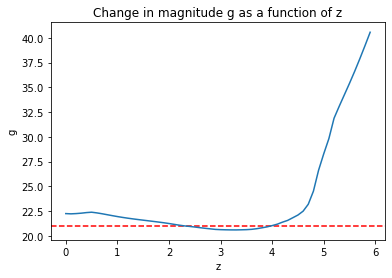

In [2]:
gr_modellrd3 = np.empty(60, dtype=float)
JKs_modellrd3 = np.empty(60, dtype=float)
z_values_model = np.empty(60, dtype=float)
g_modellrd3 = np.empty(60, dtype=float)
for nz in range(0,60):
    z = float(nz)/10.+0.0
    z_values_model[nz] = z  # Store the z value
    wave_qso_z = wave_qso*(1.+z)
    spec_qso = model_lrd3*LYMAN_BLANKET(wave_qso_z,z)
    spec_qso_resample_g =  spectres(wave_g,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_r =  spectres(wave_r,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_J =  spectres(wave_J,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_Ks =  spectres(wave_Ks,wave_qso_z,spec_qso*wave_qso_z)
    gflam = spi.simps(spec_qso_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_qso_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_qso_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_qso_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_modellrd3[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_modellrd3[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)
    g_modellrd3[nz] = -2.5*np.log10(gflam/gvega)+ABoff_g
    
plt.axhline(y=21, color='r', linestyle='--', label='y = 21')
plt.plot(z_values_model,g_modellrd3)
plt.xlabel('z')
plt.ylabel('g')
plt.title('Change in magnitude g as a function of z')
plt.show()

(20.0, 21.0)

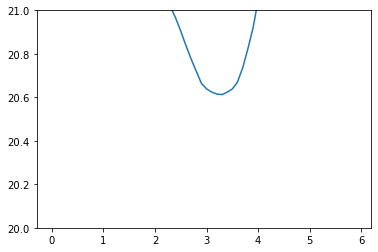

In [3]:
plt.plot(z_values_model,g_modellrd3)
plt.ylim(20,21)

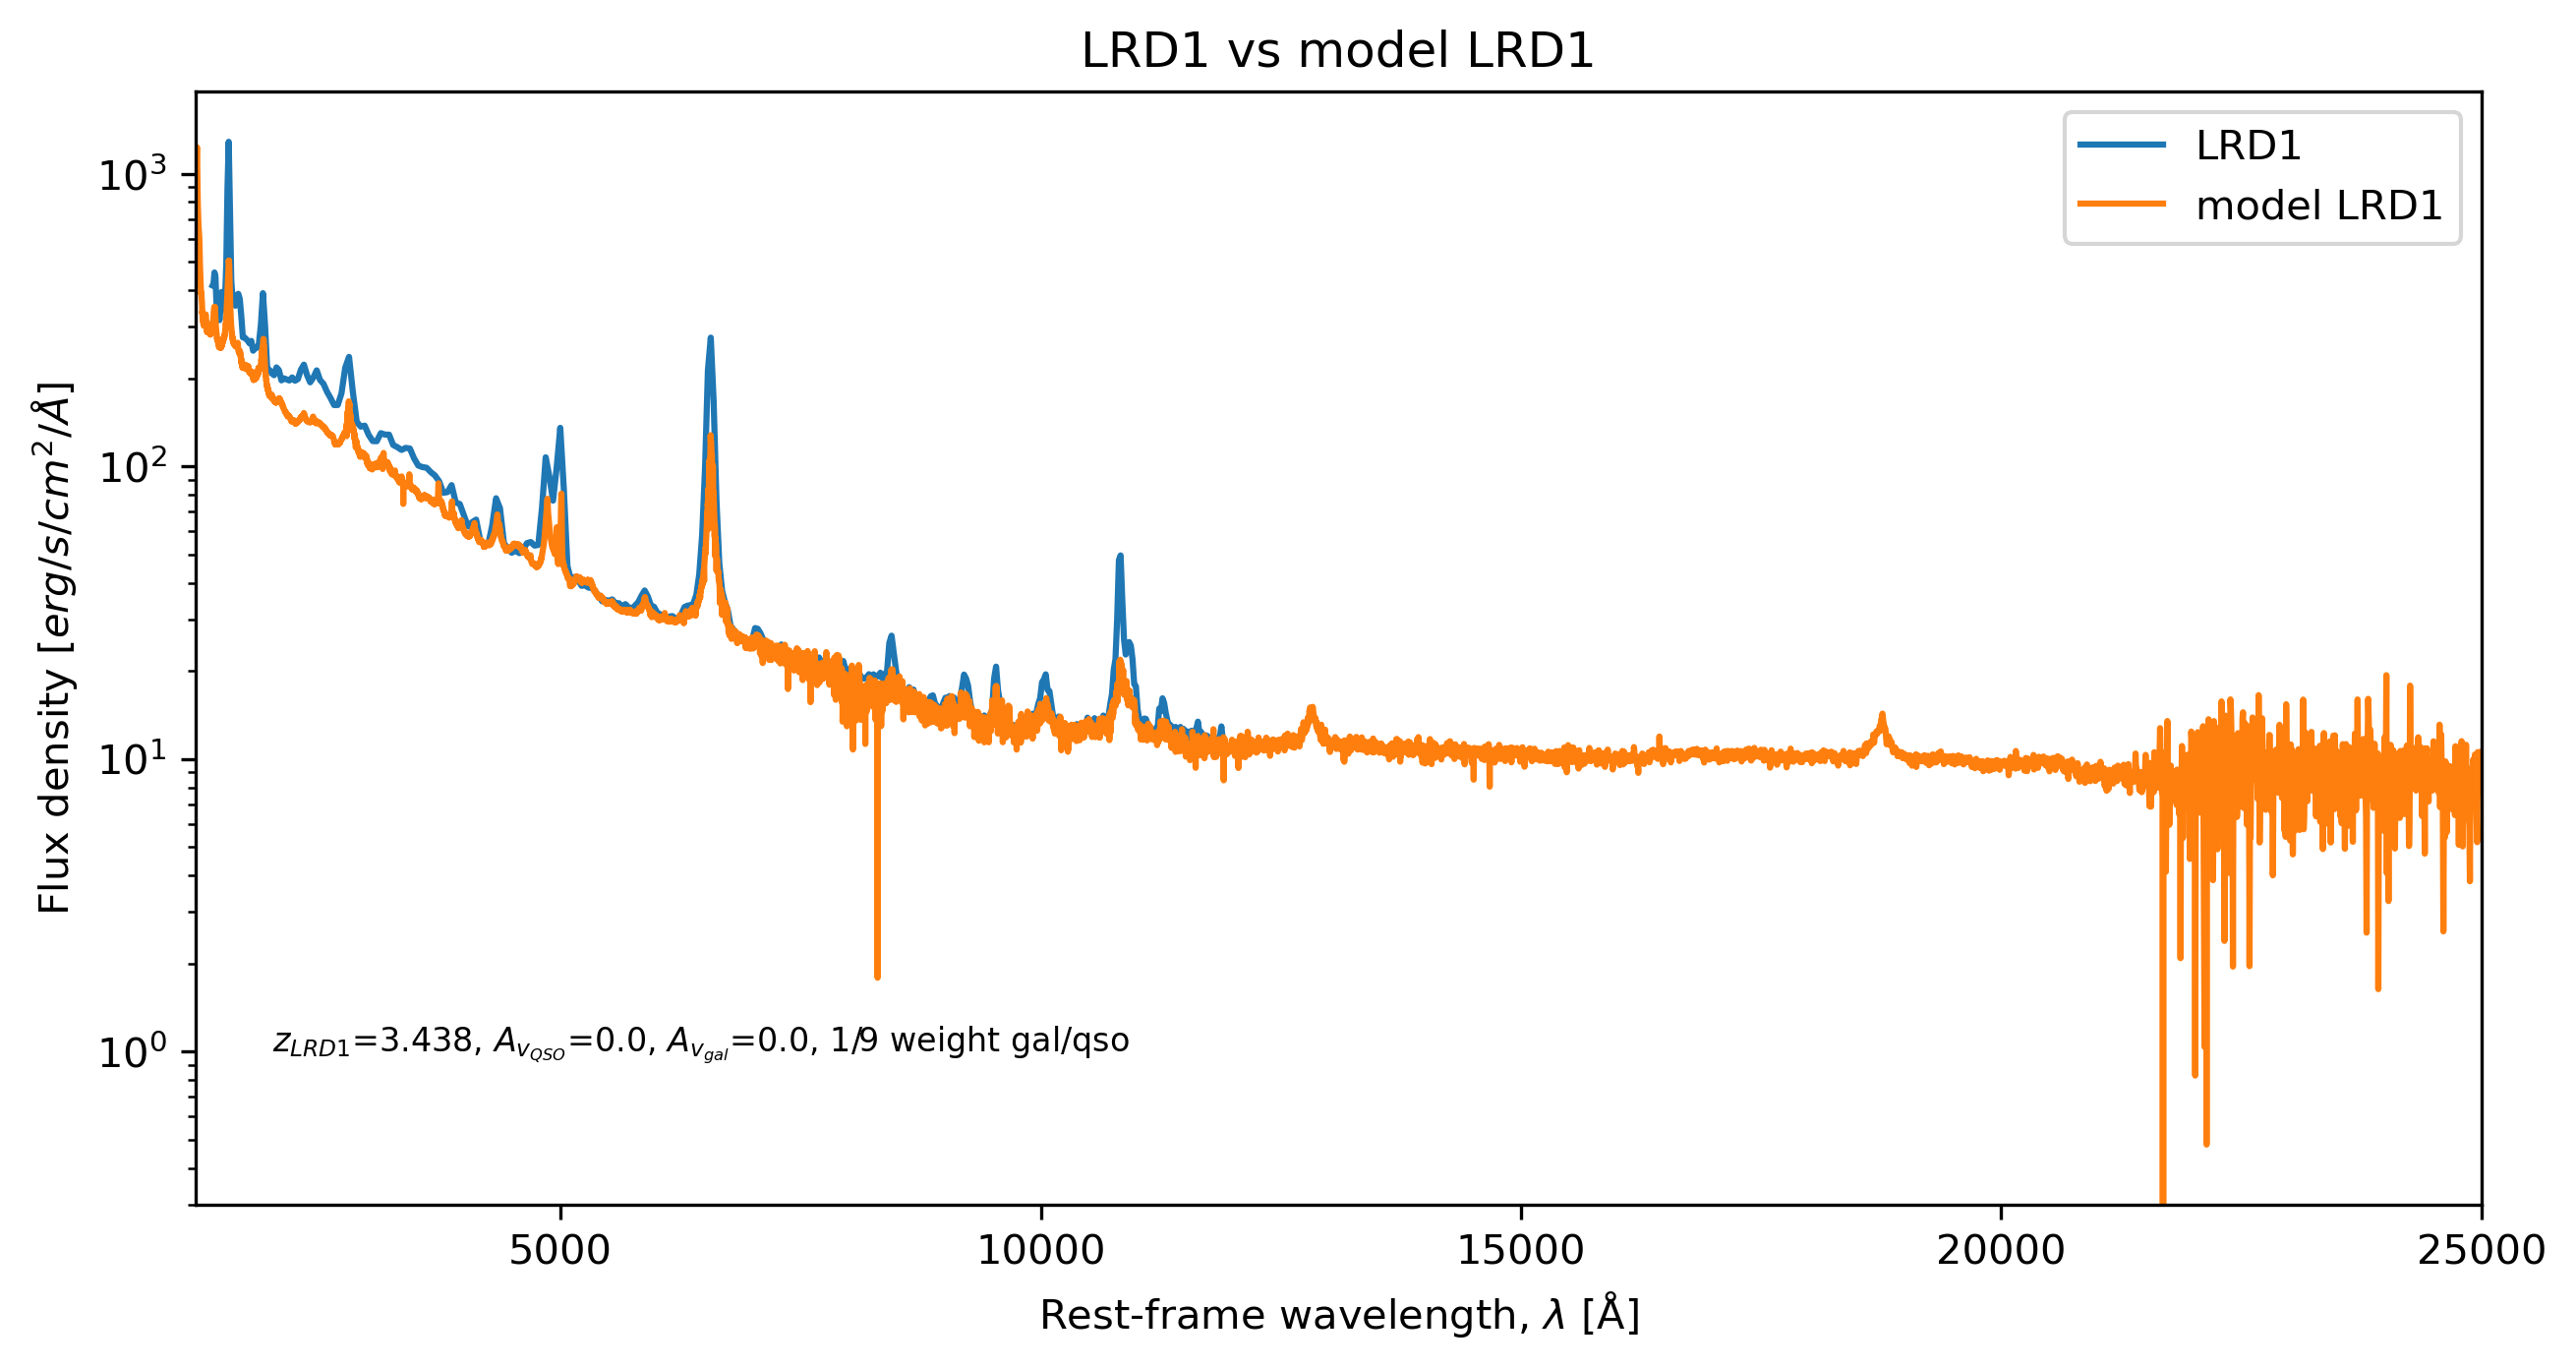

In [4]:
#LRD1
#1/9 weight to gal/qso
#Avqso = 0.0
#Avgal = 0.
plt.figure(figsize=(10,5),dpi=300)
plt.title('LRD1 vs model LRD1')
plt.plot(wave_lrd1,spec_lrd1,zorder=1,label='LRD1')
plt.plot(wave_qso,model_lrd1,zorder=1,label='model LRD1')
plt.yscale('log')
plt.xlim(1200,25000) # LRD1
plt.xlabel('Rest-frame wavelength, $\lambda$ [Å]')
plt.ylabel('Flux density $[erg/s/cm^2/Å]$')
#plt.ylim(0.01,300)
plt.text(2000,1,'$z_{LRD1}$=3.438, $A_{v_{QSO}}$=0.0, $A_{v_{gal}}$=0.0, 1/9 weight gal/qso',fontsize=8)
plt.legend()
plt.savefig('model_lrd1.png') 
plt.show()

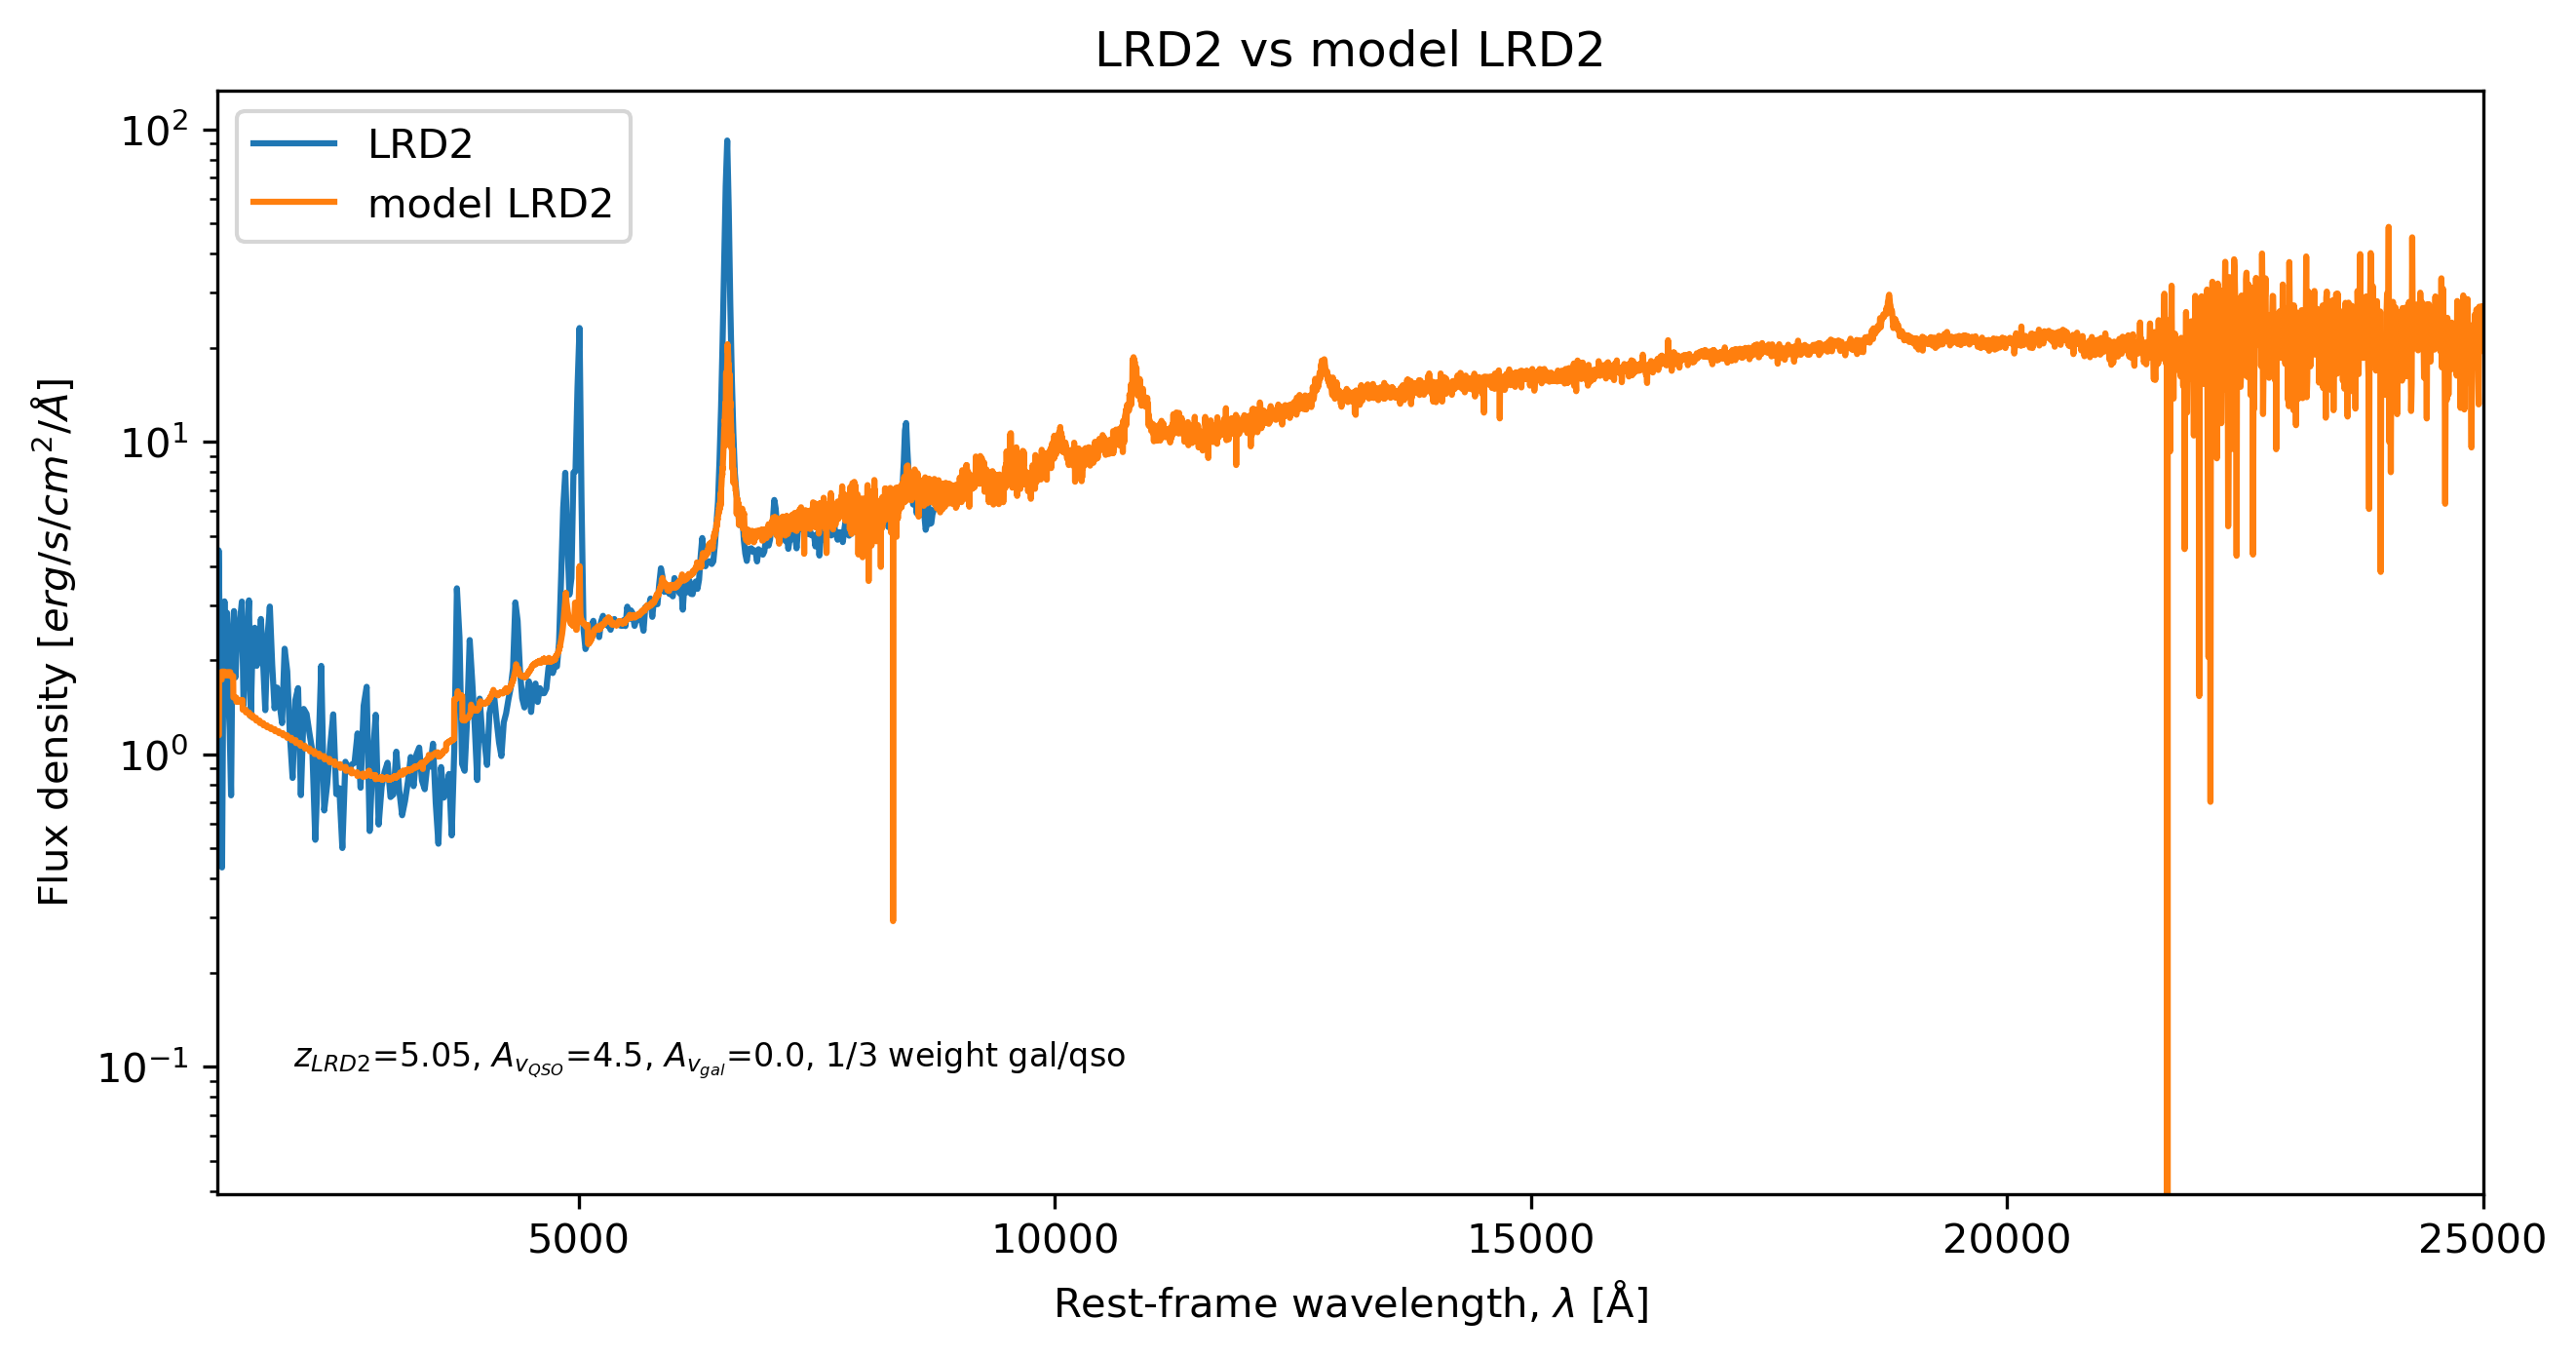

In [5]:
#LRD2
#Spec_I
#1/3 weight to gal/qso
#Avqso = 4.5
#Avgal = 0.
#normalise at 5250-5600 Å
plt.figure(figsize=(10,5),dpi=300)
plt.title('LRD2 vs model LRD2')
plt.plot(wave_lrd2,spec_lrd2,zorder=1,label='LRD2')
plt.plot(wave_qso,model_lrd2,zorder=1,label='model LRD2')
plt.yscale('log')
plt.xlim(1200,25000) # LRD2
plt.xlabel('Rest-frame wavelength, $\lambda$ [Å]')
plt.ylabel('Flux density $[erg/s/cm^2/Å]$')
#plt.ylim(0.01,300)
plt.text(2000,0.1,'$z_{LRD2}$=5.05, $A_{v_{QSO}}$=4.5, $A_{v_{gal}}$=0.0, 1/3 weight gal/qso',fontsize=8)
plt.legend()
plt.savefig('model_lrd2.png') 
plt.show()

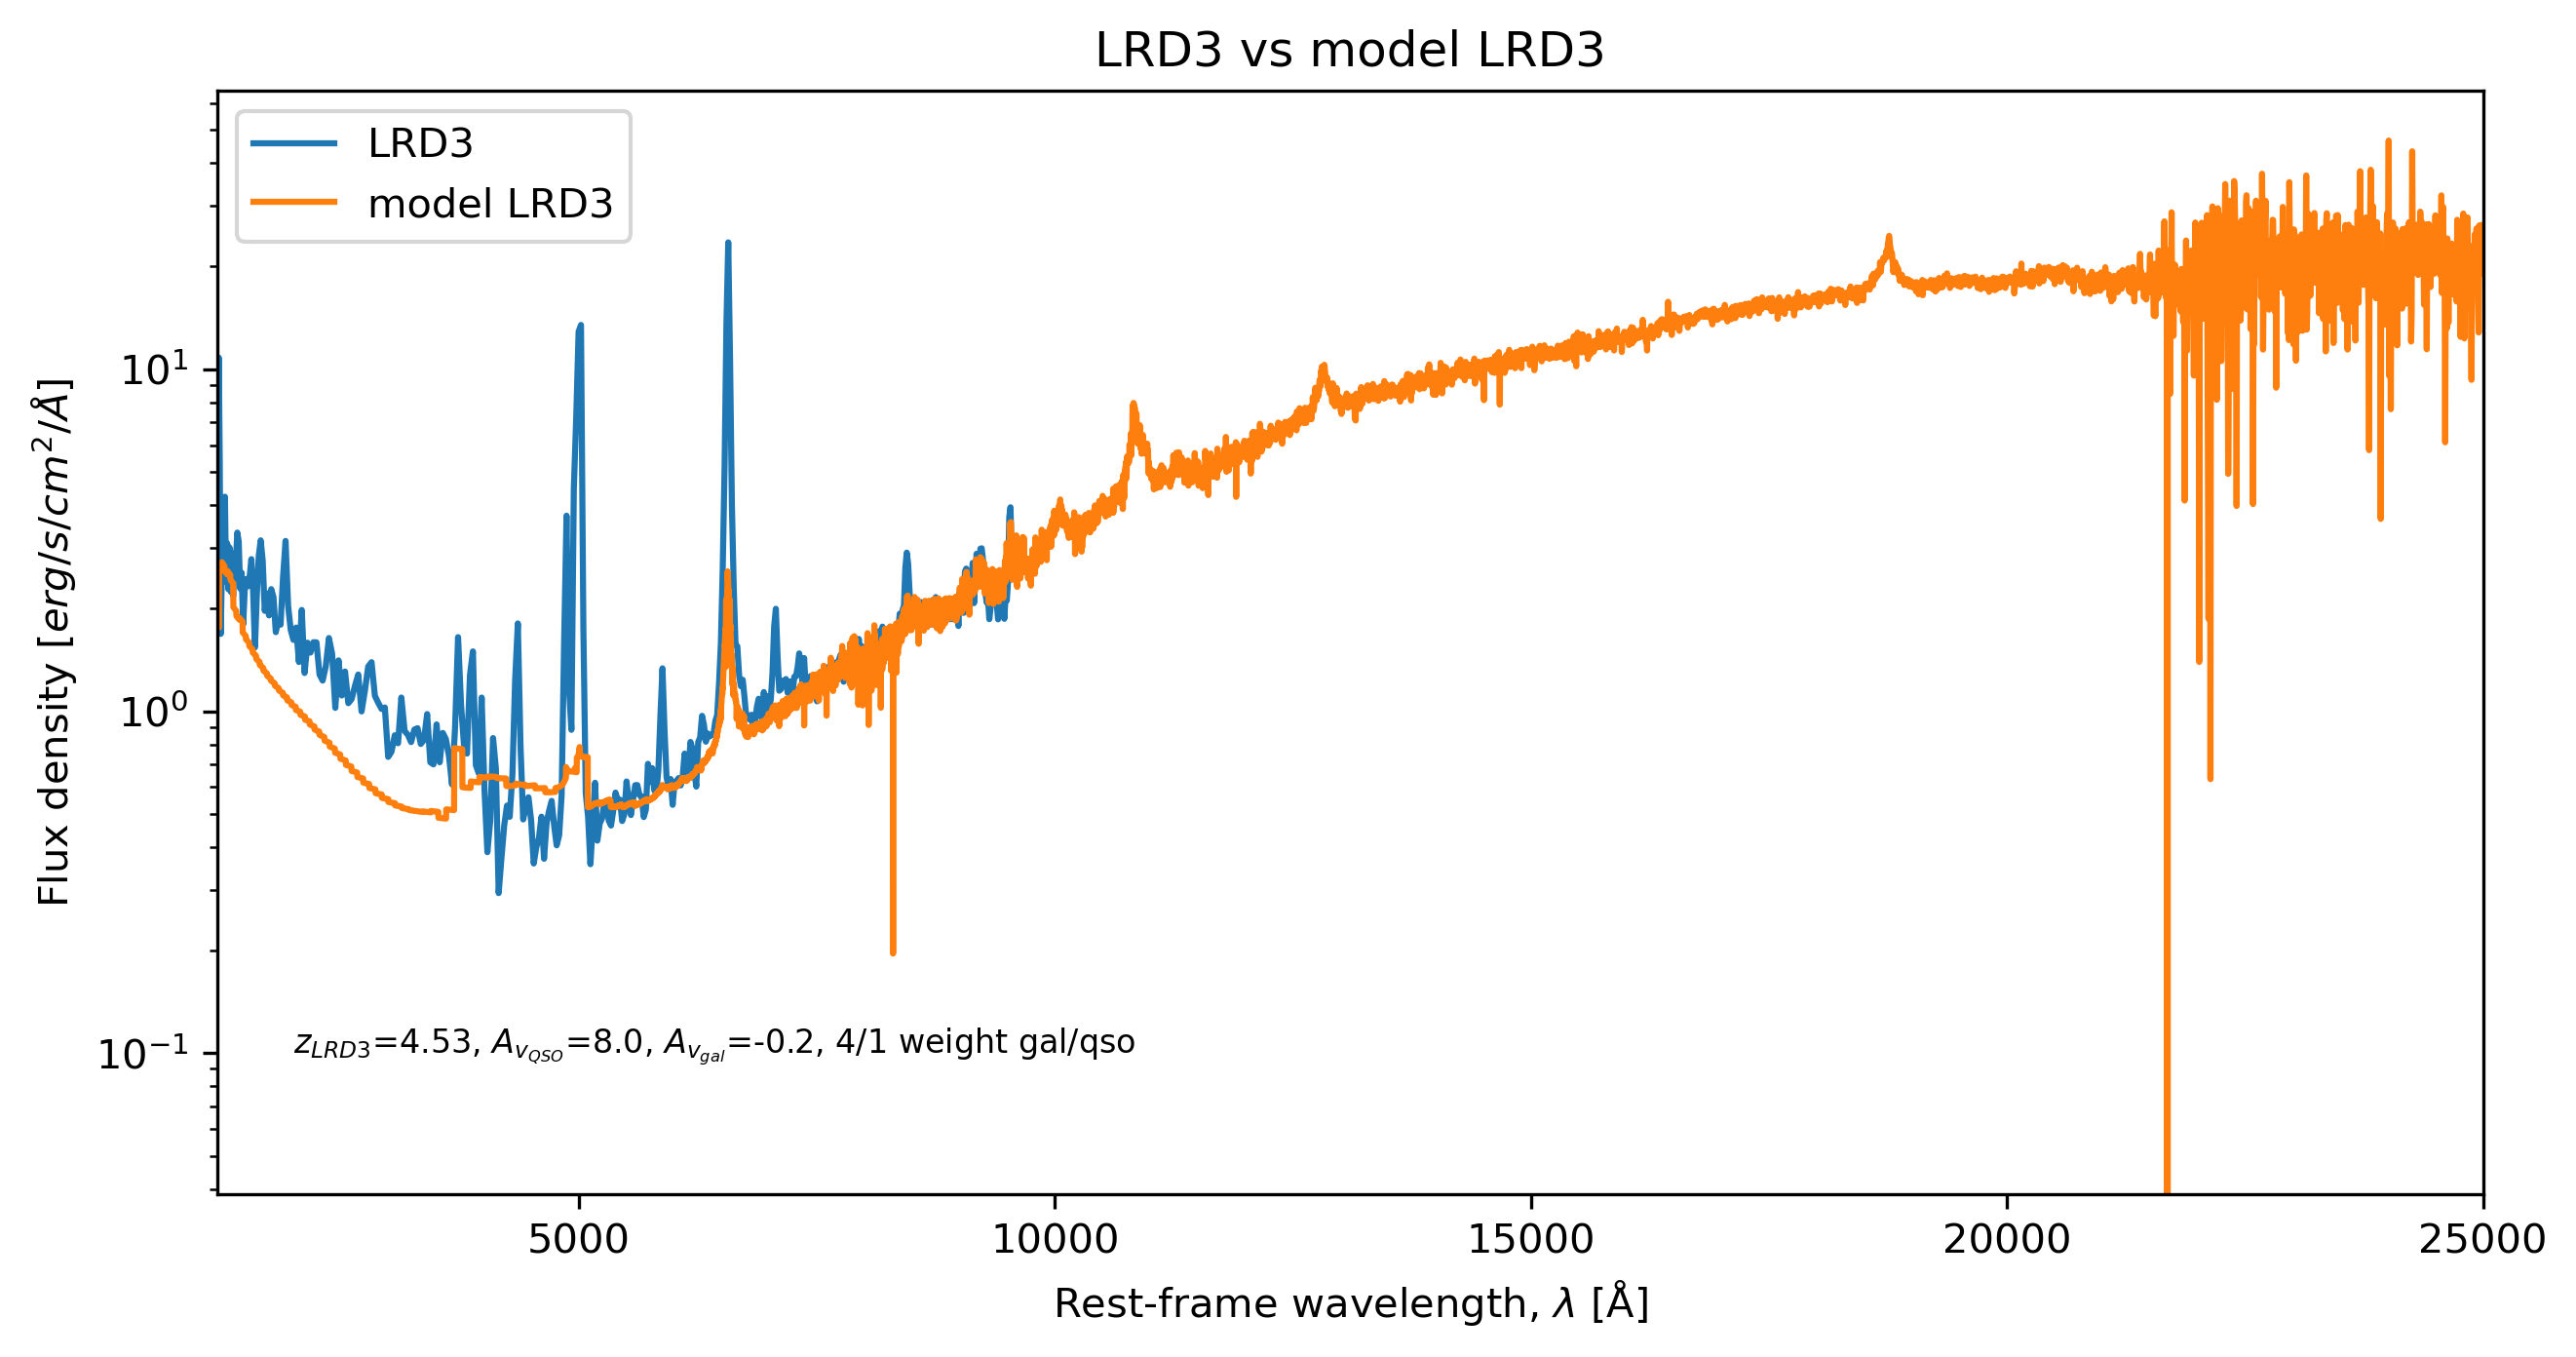

In [6]:
#LRD3:
#Spec_I
#4/1 weight to gal/qso
#Avqso = 8.0
#Avgal = -0.2
#normalise at 5250-5600 Å
plt.figure(figsize=(10,5),dpi=300)
plt.title('LRD3 vs model LRD3')
plt.plot(wave_lrd3,spec_lrd3,zorder=1,label='LRD3')
plt.plot(wave_qso,model_lrd3,zorder=1,label='model LRD3')
plt.yscale('log')
plt.xlim(1200,25000) # LRD3
plt.xlabel('Rest-frame wavelength, $\lambda$ [Å]')
plt.ylabel('Flux density $[erg/s/cm^2/Å]$')
#plt.ylim(0.01,300)
plt.text(2000,0.1,'$z_{LRD3}$=4.53, $A_{v_{QSO}}$=8.0, $A_{v_{gal}}$=-0.2, 4/1 weight gal/qso',fontsize=8)
plt.legend()
plt.savefig('model_lrd3.png') 
plt.show()

In [7]:
#PAQSsurverydata
data = np.loadtxt('PAQSsurveyphotometry.dat', skiprows=1)
ID = data[:,0]              #Rektascension fra GAIA kataloget
RA = data[:,1]              #Rektascension fra GAIA kataloget
Dec = data[:,2]             #Deklination fra GAIA kataloget

u_ATLAS = data[:,3]          # u-filter størrelsesklasse (ATLAS)
err_u_ATLAS = data[:,4]        # usikkerhed på u-filter størrelsesklasse (ATLAS)
g_ATLAS = data[:,5]          # g-filter størrelsesklasse (ATLAS)
err_g_ATLAS = data[:,6]        # usikkerhed på g-filter størrelsesklasse (ATLAS)
r_ATLAS = data[:,7]          # r-filter størrelsesklasse (ATLAS)
err_r_ATLAS = data[:,8]       # usikkerhed på r-filter størrelsesklasse (ATLAS)
i_ATLAS = data[:,9]         # i-filter størrelsesklasse (ATLAS)
err_i_ATLAS = data[:,10]       # usikkerhed på i-filter størrelsesklasse (ATLAS)
z_ATLAS = data[:,11]         # z-filter størrelsesklasse (ATLAS)
err_z_ATLAS = data[:,12]       # usikkerhed på z-filter størrelsesklasse (ATLAS)
g_DES = data[:,13]
err_g_DES = data[:,14]
r_DES = data[:,15]
err_r_DES = data[:,16]
i_DES = data[:,17]
err_i_DES = data[:,18]
z_DES = data[:,19]
err_z_DES = data[:,20]
y_DES = data[:,21]
err_y_DES = data[:,22]
y_VHS = data[:,23]
err_y_VHS = data[:,24]
j_VHS = data[:,25]
err_j_VHS = data[:,26]
h_VHS = data[:,27]
err_h_VHS = data[:,28]
ks_VHS = data[:,29]
err_ks_VHS = data[:,30]

#Lav farve-farve plottet
errlim = 0.1
good = np.where((err_g_ATLAS < errlim) & (err_r_ATLAS < errlim) & (err_j_VHS < errlim) & (err_ks_VHS < errlim))

x=j_VHS[good]-ks_VHS[good]    # VEGA
y=g_ATLAS[good]-r_ATLAS[good] # AB

In [8]:
#Read spectrum of vega
tab = np.loadtxt('vega.dat')
wave_vega = tab[:,0]
spec_vega = tab[:,1]*1.e17

#Integrate the fluxes of vega in the four filters
spec_vega_resample_g =  spectres(wave_g,wave_vega,spec_vega*wave_vega)
gvega = spi.simps(spec_vega_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
spec_vega_resample_r =  spectres(wave_r,wave_vega,spec_vega*wave_vega)
rvega = spi.simps(spec_vega_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
spec_vega_resample_J =  spectres(wave_J,wave_vega,spec_vega*wave_vega)
Jvega = spi.simps(spec_vega_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
spec_vega_resample_Ks =  spectres(wave_Ks,wave_vega,spec_vega*wave_vega)
Ksvega = spi.simps(spec_vega_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)

#For each z in the interval from 0 to 6 calculate the g-r and J-Ks colours 
gr = np.empty(600, dtype=float)
JKs = np.empty(600, dtype=float)
for nz in range(0,600):
    z = float(nz)/100.+0.0
    wave_qso_z = wave_qso*(1.+z)
    spec_qso = spec_qso*LYMAN_BLANKET(wave_qso_z,z)
    spec_qso_resample_g =  spectres(wave_g,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_r =  spectres(wave_r,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_J =  spectres(wave_J,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_Ks =  spectres(wave_Ks,wave_qso_z,spec_qso*wave_qso_z)
    gflam = spi.simps(spec_qso_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_qso_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_qso_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_qso_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)

#Repeat with A_V=0.5. For each z in the interval from 0 to 6 calculate the g-r and J-Ks colours 
AV = 0.5
AB = AV*4.1/3.1
wlr = wave_qso/1.e4
Alambda = spec_qso*0.
for e in range(len(ai)):
   Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
   Alambda = Alambda*AB
   spec_qso = 10**(-0.4*Alambda)*spec_qso
gr_av05 = np.empty(600, dtype=float)
JKs_av05 = np.empty(600, dtype=float)
for nz in range(0,600):
    z = float(nz)/100.+0.0
    wave_qso_z = wave_qso*(1.+z)
    spec_qso = spec_qso*LYMAN_BLANKET(wave_qso_z,z)
    spec_qso_resample_g =  spectres(wave_g,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_r =  spectres(wave_r,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_J =  spectres(wave_J,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_Ks =  spectres(wave_Ks,wave_qso_z,spec_qso*wave_qso_z)
    gflam = spi.simps(spec_qso_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_qso_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_qso_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_qso_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_av05[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_av05[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)

#Repeat with A_V=0.7. For each z in the interval from 0 to 6 calculate the g-r and J-Ks colours 
AV = 0.7
AB = AV*4.1/3.1
wlr = wave_qso/1.e4
Alambda = spec_qso*0.
for e in range(len(ai)):
   Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
   Alambda = Alambda*AB
   spec_qso = 10**(-0.4*Alambda)*spec_qso
gr_av07 = np.empty(600, dtype=float)
JKs_av07 = np.empty(600, dtype=float)
for nz in range(0,600):
    z = float(nz)/100.+0.0
    wave_qso_z = wave_qso*(1.+z)
    spec_qso = spec_qso*LYMAN_BLANKET(wave_qso_z,z)
    spec_qso_resample_g =  spectres(wave_g,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_r =  spectres(wave_r,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_J =  spectres(wave_J,wave_qso_z,spec_qso*wave_qso_z)
    spec_qso_resample_Ks =  spectres(wave_Ks,wave_qso_z,spec_qso*wave_qso_z)
    gflam = spi.simps(spec_qso_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    rflam = spi.simps(spec_qso_resample_r*transm_r, wave_r)/spi.simps(transm_r*wave_r, wave_r)
    Jflam = spi.simps(spec_qso_resample_J*transm_J, wave_J)/spi.simps(transm_J*wave_J, wave_J)
    Ksflam = spi.simps(spec_qso_resample_Ks*transm_Ks, wave_Ks)/spi.simps(transm_Ks*wave_Ks, wave_Ks)
    gr_av07[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
    JKs_av07[nz] = -2.5*np.log10(Jflam/Ksflam*Ksvega/Jvega)

<ipython-input-8-33aea5a3f016>:31: RuntimeWarning: divide by zero encountered in log10
  gr[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
<ipython-input-8-33aea5a3f016>:57: RuntimeWarning: divide by zero encountered in log10
  gr_av05[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r
<ipython-input-8-33aea5a3f016>:83: RuntimeWarning: divide by zero encountered in log10
  gr_av07[nz] = -2.5*np.log10(gflam/rflam*rvega/gvega)+ABoff_g-ABoff_r


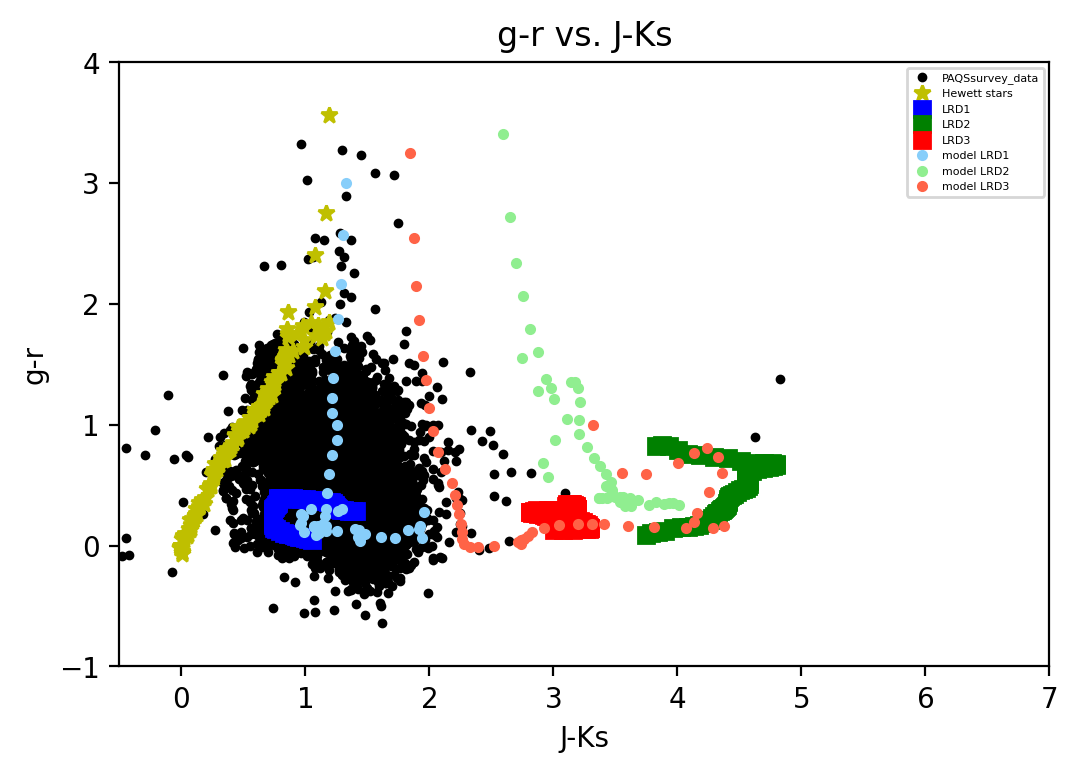

In [9]:
#Make plot
plt.figure(dpi=200)
plt.title('g-r vs. J-Ks')
plt.plot(x,y,'o',color='black',markersize=2.5,label='PAQSsurvey_data')
plt.plot(JK_8, gr_8, '*',color='y', label='Hewett stars')
plt.plot(JKs_lrd1, gr_lrd1, 's',color='b', label='LRD1')
plt.plot(JKs_lrd2, gr_lrd2, 's',color='g', label='LRD2')
plt.plot(JKs_lrd3, gr_lrd3, 's',color='r', label='LRD3')
plt.plot(JKs_modellrd1, gr_modellrd1, '.',color='lightskyblue', label='model LRD1')
plt.plot(JKs_modellrd2, gr_modellrd2, '.',color='lightgreen', label='model LRD2')
plt.plot(JKs_modellrd3, gr_modellrd3, '.',color='tomato', label='model LRD3')
#plt.plot(JKs_av05, gr_av05, '.',color='violet', label='compoM, A_V=0.5')
#plt.plot(JKs_av07, gr_av07, '.',color='pink', label='compoM, A_V=0.7')
plt.xlabel('J-Ks')
plt.ylabel('g-r')
plt.xlim(-0.5,7)
plt.ylim(-1,4)
plt.legend(prop={'size':4})
plt.show()


In [10]:
#Read quasar template
tab = np.loadtxt('compoM.data')
wave_qso = tab[:,0]
spec_qso = tab[:,1]


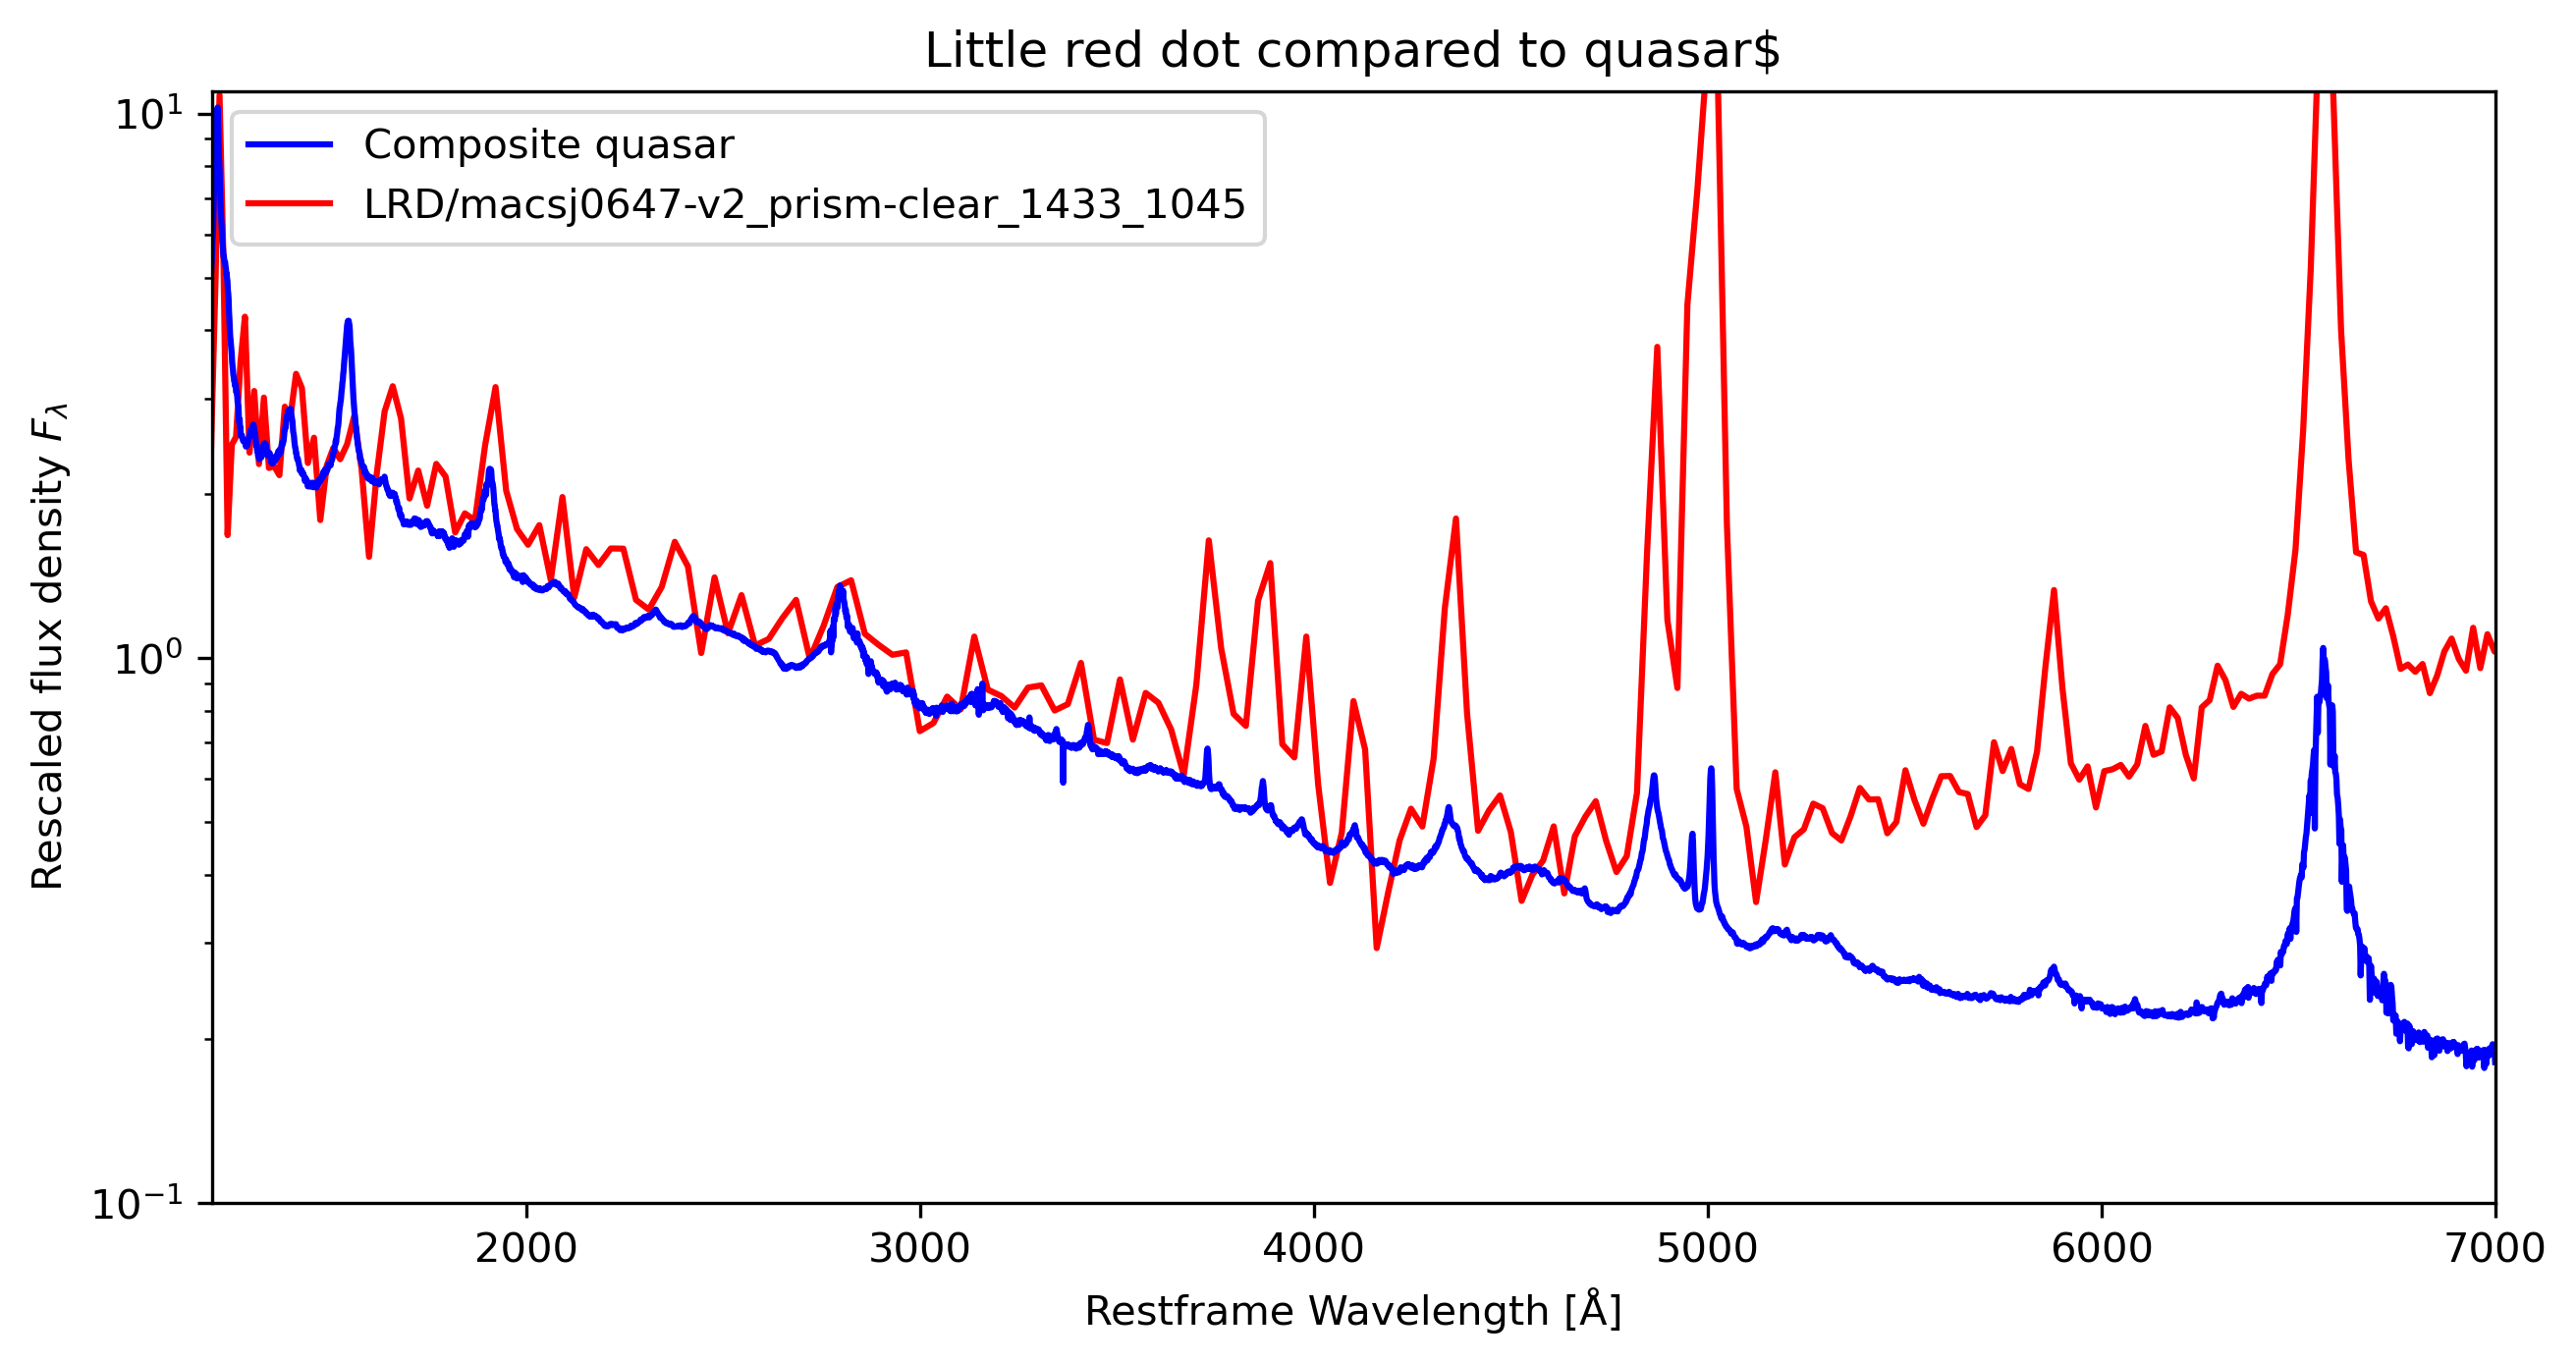

''

In [11]:
plt.figure(figsize=(10,5),dpi=300)
plt.title('Little red dot compared to quasar$')
plt.plot(wave_qso,spec_qso, label='Composite quasar',color='blue')
plt.xlim(1200,7000)
plt.yscale('log')
plt.xlabel('Restframe Wavelength [Å]')
plt.ylabel('Rescaled flux density $F_{\lambda}$')
plt.ylim(0.1,11)
plt.plot(wave_lrd3,spec_lrd3,zorder=1,label='LRD/macsj0647-v2_prism-clear_1433_1045',color='red')
plt.legend()
plt.savefig('lrd_vs_qso.png') 
plt.show()
;


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

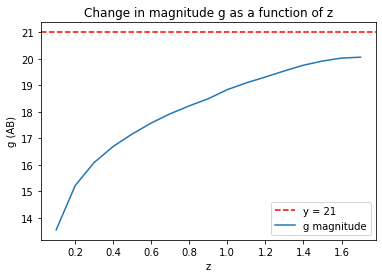

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from spectres import spectres
import scipy.integrate as spi
from astropy.io import fits

def drdz(z):
    return cH / np.sqrt((1 + z)**2 * (Omega * z + 1) - OL * z * (z + 2))

def r(z):
    I = spi.quad(drdz, 0, z)
    return I[0]

def D(z):
    if kappa < 0.:
        Rtilt = 1 / np.sqrt(-kappa)
        res = Rtilt * np.sinh(r(z) / Rtilt)
    elif kappa > 0.:
        Rtilt = 1 / np.sqrt(kappa)
        res = Rtilt * np.sin(r(z) / Rtilt)
    else:
        res = r(z)
    return res

def LumDist(z):
    return D(z) * (1 + z)

OL = 0.70
Omega = 1. - OL
cH = 2997.92458 / 0.70
kappa = (Omega + OL - 1.) / cH**2.

# Read transmission curves for g
tab = np.loadtxt('SDSS_g.data')
wave_g = tab[:, 0]
transm_g = tab[:, 1]

# Read LRD1 spectra
zlrd1 = 3.48
HDU = fits.open('LRD/ceers-ddt-v2_prism-clear_2750_1034.spec.fits')
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd1 = spec1d['wave'] * 10000.  # wavelength in AA
spec_lrd1 = spec1d['flux'] * 1.e-29  # Flux in F_nu cgs

z_values_model = np.empty(60, dtype=float)
gab = np.empty(60, dtype=float)

for nz in range(60):
    z = float(nz) / 10.0 + 0.1
    z_values_model[nz] = z  # Store the z value

    # Adjust the wavelengths and spectrum for the new redshift
    wave_lrd1_znew = wave_lrd1 * (1 + z) / (1 + zlrd1)
    spec_lrd1_znew = spec_lrd1 * (LumDist(zlrd1) / LumDist(z))**2 * (1 + z) / (1 + zlrd1)

    # Resample the spectrum to match the g filter wavelengths
    spec_lrd1_znew_resample_g = spectres(wave_g, wave_lrd1_znew, spec_lrd1_znew)

    # Calculate the gmean
    gmean = spi.simps(spec_lrd1_znew_resample_g * transm_g * wave_g, wave_g) / spi.simps(transm_g * wave_g, wave_g)

    # Calculate the AB magnitude
    gab[nz] = -48.6 - 2.5 * np.log10(gmean)

plt.axhline(y=21, color='r', linestyle='--', label='y = 21')
plt.plot(z_values_model, gab, label='g magnitude')
plt.xlabel('z')
plt.ylabel('g (AB)')
plt.title('Change in magnitude g as a function of z')
plt.legend()
plt.show()

-0.103


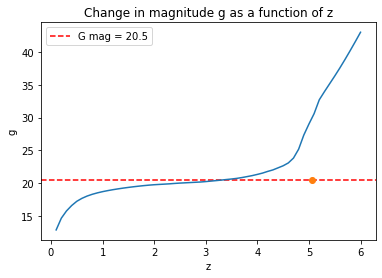

In [14]:
zlrd2=5.05
gr_modellrd2 = np.empty(60, dtype=float)
JKs_modellrd2 = np.empty(60, dtype=float)
z_values_mode2 = np.empty(60, dtype=float)
g_modellrd2 = np.empty(60, dtype=float)
for nz in range(0,60):
    z = float(nz)/10.+0.1
    z_values_model[nz] = z  # Store the z value
    wave_qso_z = wave_qso*(1.+z)
    spec_qso = model_lrd2*LYMAN_BLANKET(wave_qso_z,z)
    spec_qso_resample_g =  spectres(wave_g,wave_qso_z,spec_qso*wave_qso_z)
    gflam = spi.simps(spec_qso_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    spec_lrd2*(LumDist(zlrd2)/LumDist(z))**2*(1+z)/(1+zlrd2)
    
    adjusted_flux2 = gflam * (LumDist(zlrd2) / LumDist(z)) ** 2 * (1.0 + z) / (1.0 + zlrd2)

    g_modellrd2[nz] = -2.5 * np.log10(adjusted_flux2 / gvega) + ABoff_g
    
print(ABoff_g)
# Plot the results
plt.axhline(y=20.5, color='r', linestyle='--', label='G mag = 20.5')
plt.plot(z_values_model, g_modellrd2)
plt.plot(5.05,20.5,'o')
plt.xlabel('z')
plt.ylabel('g')
plt.title('Change in magnitude g as a function of z')
plt.legend()
plt.show()

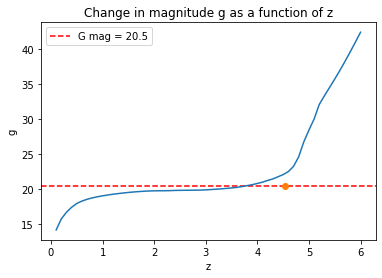

In [15]:
zlrd3=4.53
gr_modellrd3 = np.empty(60, dtype=float)
JKs_modellrd3 = np.empty(60, dtype=float)
z_values_mode3 = np.empty(60, dtype=float)
g_modellrd3 = np.empty(60, dtype=float)
for nz in range(0,60):
    z = float(nz)/10.+0.1
    z_values_model[nz] = z  # Store the z value
    wave_qso_z = wave_qso*(1.+z)
    spec_qso = model_lrd3*LYMAN_BLANKET(wave_qso_z,z)
    spec_qso_resample_g =  spectres(wave_g,wave_qso_z,spec_qso*wave_qso_z)
    gflam = spi.simps(spec_qso_resample_g*transm_g, wave_g)/spi.simps(transm_g*wave_g, wave_g)
    spec_lrd3*(LumDist(zlrd3)/LumDist(z))**2*(1+z)/(1+zlrd3)
    
    adjusted_flux3 = gflam * (LumDist(zlrd3) / LumDist(z)) ** 2 * (1.0 + z) / (1.0 + zlrd3)

    g_modellrd3[nz] = -2.5 * np.log10(adjusted_flux3 / gvega) + ABoff_g
    

# Plot the results
plt.axhline(y=20.5, color='r', linestyle='--', label='G mag = 20.5')
plt.plot(z_values_model, g_modellrd3)
plt.plot(4.53,20.5,'o')
plt.xlabel('z')
plt.ylabel('g')
plt.title('Change in magnitude g as a function of z')
plt.legend()
plt.show()

This script models how the observed g-band magnitude of a quasar changes as it is redshifted from z = 0.1 to z = 6.0. The magnitude calculations account for the changing luminosity distance and redshift effects, providing a visual representation of the magnitude evolution over different redshifts. This kind of analysis is crucial for understanding the properties and evolution of quasars and other celestial objects in an expanding universe.

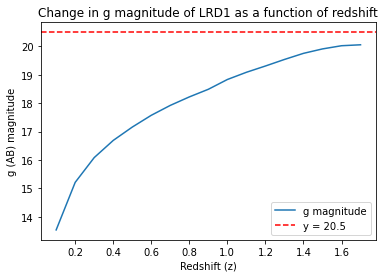

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from spectres import spectres
import scipy.integrate as spi
from astropy.io import fits

def drdz(z):
    return cH/np.sqrt((1+z)**2*(Omega*z+1)-OL*z*(z+2))

def r(z):
    I = spi.quad(drdz,0,z)
    return I[0]

def D(z):
    if kappa < 0.:
        Rtilt = 1/np.sqrt(-kappa)
        res = Rtilt*np.sinh(r(z)/Rtilt)
    elif kappa > 0.:
        Rtilt = 1/np.sqrt(kappa)
        res = Rtilt*np.sin(r(z)/Rtilt)
    else:
        res = r(z)
    return res

def LumDist(z):
    return D(z)*(1+z)

OL = 0.70
Omega = 1. - OL
cH = 2997.92458 / 0.70
kappa = (Omega + OL - 1.) / cH**2

# Read transmission curves for g, r
tab = np.loadtxt('SDSS_g.data')
wave_g = tab[:,0]
transm_g = tab[:,1]

# Read LRD1 spectra
zlrd1 = 3.48
HDU = fits.open('LRD/ceers-ddt-v2_prism-clear_2750_1034.spec.fits')
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd1 = spec1d.wave * 10000.  # wavelength in AA
spec_lrd1 = spec1d.flux * 1.e-29  # Flux in F_nu cgs

# Initialize arrays to store redshift and g magnitudes
z_values_model = np.empty(60, dtype=float)
g_modellrd1 = np.empty(60, dtype=float)

# Vega to AB offset for g-band (typically 0.03 for SDSS)
ABoff_g = 0.03

for nz in range(60):
    z = float(nz) / 10. + 0.1
    z_values_model[nz] = z  # Store the z value
    
    # Redshift the spectrum
    wave_lrd1_znew = wave_lrd1 * (1 + z) / (1 + zlrd1)
    spec_lrd1_znew = spec_lrd1 * (LumDist(zlrd1) / LumDist(z))**2 * (1 + z) / (1 + zlrd1)
    
    # Find the overlap range
    min_wave = max(wave_g.min(), wave_lrd1_znew.min())
    max_wave = min(wave_g.max(), wave_lrd1_znew.max())
    
    # Only process if there is an overlap
    if min_wave < max_wave:
        # Mask the transmission curve to the overlapping range
        mask_g = (wave_g >= min_wave) & (wave_g <= max_wave)
        wave_g_masked = wave_g[mask_g]
        transm_g_masked = transm_g[mask_g]
        
        # Resample the redshifted spectrum to the g-band wavelengths
        spec_lrd1_znew_resample_g = spectres(wave_g_masked, wave_lrd1_znew, spec_lrd1_znew)
        
        # Calculate the g-band flux
        gmean = spi.simps(spec_lrd1_znew_resample_g * transm_g_masked * wave_g_masked, wave_g_masked) / spi.simps(transm_g_masked * wave_g_masked, wave_g_masked)
        
        # Convert to AB magnitude
        gab = -48.6 - 2.5 * np.log10(gmean)
        
        # Store the g magnitude
        g_modellrd1[nz] = gab
    else:
        # If no overlap, assign a large magnitude value to indicate no detection
        g_modellrd1[nz] = np.inf

# Plot the results
plt.figure()
plt.plot(z_values_model, g_modellrd1, label='g magnitude')
plt.axhline(y=20.5, color='r', linestyle='--', label='y = 20.5')
plt.xlabel('Redshift (z)')
plt.ylabel('g (AB) magnitude')
plt.title('Change in g magnitude of LRD1 as a function of redshift')
plt.legend()
plt.show()

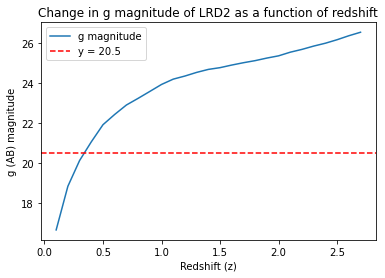

In [28]:
# Read LRD2 spectra
zlrd2 = 5.05
HDU2 = fits.open('LRD/jades-gdn-v2_prism-clear_1181_68797.spec.fits')
spec1d = HDU2[1].data
wave_lrd2 = spec1d['wave'] * 10000.  # wavelength in AA
spec_lrd2 = spec1d['flux'] * 1.e-29  # Flux in F_nu cgs

# Initialize arrays to store redshift and g magnitudes
z_values_model = np.empty(60, dtype=float)
g_modellrd2 = np.empty(60, dtype=float)

# Vega to AB offset for g-band (typically 0.03 for SDSS)
ABoff_g = 0.03

for nz in range(60):
    z = float(nz) / 10. + 0.1
    z_values_model[nz] = z  # Store the z value
    
    # Redshift the spectrum
    wave_lrd2_znew = wave_lrd2 * (1 + z) / (1 + zlrd2)
    spec_lrd2_znew = spec_lrd2 * (LumDist(zlrd2) / LumDist(z))**2 * (1 + z) / (1 + zlrd2)
    
    # Find the overlap range
    min_wave = max(wave_g.min(), wave_lrd2_znew.min())
    max_wave = min(wave_g.max(), wave_lrd2_znew.max())
    
    # Only process if there is an overlap
    if min_wave < max_wave:
        # Mask the transmission curve to the overlapping range
        mask_g = (wave_g >= min_wave) & (wave_g <= max_wave)
        wave_g_masked = wave_g[mask_g]
        transm_g_masked = transm_g[mask_g]
        
        # Resample the redshifted spectrum to the g-band wavelengths
        spec_lrd2_znew_resample_g = spectres(wave_g_masked, wave_lrd2_znew, spec_lrd2_znew)
        
        # Calculate the g-band flux
        gmean = spi.simps(spec_lrd2_znew_resample_g * transm_g_masked * wave_g_masked, wave_g_masked) / spi.simps(transm_g_masked * wave_g_masked, wave_g_masked)
        
        # Convert to AB magnitude
        gab = -48.6 - 2.5 * np.log10(gmean)
        
        # Store the g magnitude
        g_modellrd2[nz] = gab
    else:
        # If no overlap, assign a large magnitude value to indicate no detection
        g_modellrd2[nz] = np.inf

# Plot the results
plt.figure()
plt.plot(z_values_model, g_modellrd2, label='g magnitude')
plt.axhline(y=20.5, color='r', linestyle='--', label='y = 20.5')
plt.xlabel('Redshift (z)')
plt.ylabel('g (AB) magnitude')
plt.title('Change in g magnitude of LRD2 as a function of redshift')
plt.legend()
plt.show()

In [25]:
print(z_values_model)
print(g_modellrd2)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6
 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3 5.4
 5.5 5.6 5.7 5.8 5.9 6. ]
[16.65548858 18.84209158 20.13200941 21.06797516 21.9279761  22.44223081
 22.91443066 23.24835309 23.59502561 23.94491547 24.2106746  24.36649024
 24.54904914 24.69874802 24.78653723 24.9167841  25.03401513 25.13825563
 25.2668013  25.37876774 25.56169499 25.70204113 25.86756675 26.0111213
 26.18674951 26.38538905 26.56083294         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         inf         inf         inf         inf         inf
         inf         inf         inf         inf         inf         inf]


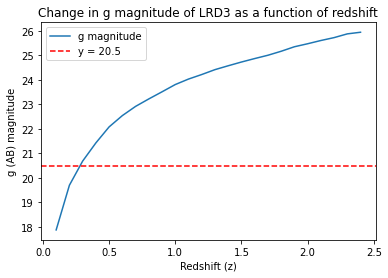

In [30]:
#Read LRD3 spectra
zlrd3=4.53
#from 1.7 to 2.3
HDU = fits.open('LRD/macsj0647-v2_prism-clear_1433_1045.spec.fits')
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd3 = spec1d.wave*10000. # wavelength in AA
spec_lrd3 = spec1d.flux*1.e-29 # Flux in F_nu cgs

# Initialize arrays to store redshift and g magnitudes
z_values_model = np.empty(60, dtype=float)
g_modellrd3 = np.empty(60, dtype=float)

# Vega to AB offset for g-band (typically 0.03 for SDSS)
ABoff_g = 0.03

for nz in range(60):
    z = float(nz) / 10. + 0.1
    z_values_model[nz] = z  # Store the z value
    
    # Redshift the spectrum
    wave_lrd3_znew = wave_lrd3 * (1 + z) / (1 + zlrd3)
    spec_lrd3_znew = spec_lrd3 * (LumDist(zlrd3) / LumDist(z))**2 * (1 + z) / (1 + zlrd3)
    
    # Find the overlap range
    min_wave = max(wave_g.min(), wave_lrd3_znew.min())
    max_wave = min(wave_g.max(), wave_lrd3_znew.max())
    
    # Only process if there is an overlap
    if min_wave < max_wave:
        # Mask the transmission curve to the overlapping range
        mask_g = (wave_g >= min_wave) & (wave_g <= max_wave)
        wave_g_masked = wave_g[mask_g]
        transm_g_masked = transm_g[mask_g]
        
        # Resample the redshifted spectrum to the g-band wavelengths
        spec_lrd3_znew_resample_g = spectres(wave_g_masked, wave_lrd3_znew, spec_lrd3_znew)
        
        # Calculate the g-band flux
        gmean = spi.simps(spec_lrd3_znew_resample_g * transm_g_masked * wave_g_masked, wave_g_masked) / spi.simps(transm_g_masked * wave_g_masked, wave_g_masked)
        
        # Convert to AB magnitude
        gab = -48.6 - 2.5 * np.log10(gmean)
        
        # Store the g magnitude
        g_modellrd3[nz] = gab
    else:
        # If no overlap, assign a large magnitude value to indicate no detection
        g_modellrd3[nz] = np.inf

# Plot the results
plt.figure()
plt.plot(z_values_model, g_modellrd3, label='g magnitude')
plt.axhline(y=20.5, color='r', linestyle='--', label='y = 20.5')
plt.xlabel('Redshift (z)')
plt.ylabel('g (AB) magnitude')
plt.title('Change in g magnitude of LRD3 as a function of redshift')
plt.legend()
plt.show()

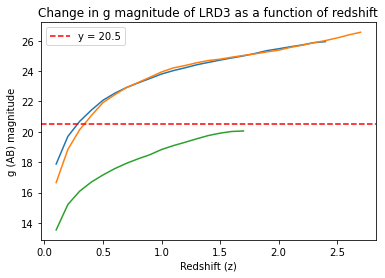

In [33]:
plt.figure
plt.plot(z_values,g_modellrd3)
plt.plot(z_values,g_modellrd2)
plt.plot(z_values,g_modellrd1)
plt.axhline(y=20.5, color='r', linestyle='--', label='y = 20.5')
plt.xlabel('Redshift (z)')
plt.ylabel('g (AB) magnitude')
plt.title('Change in g magnitude of LRD3 as a function of redshift')
plt.legend()
plt.show()

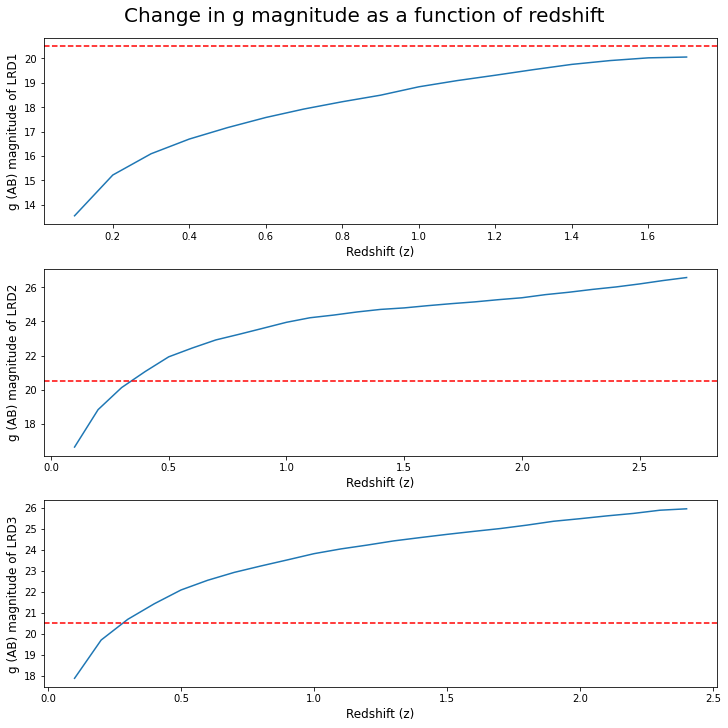

In [64]:
fig, (ax1, ax2,ax3) = plt.subplots(3,constrained_layout=True, figsize=(10, 10))
fig.suptitle('Change in g magnitude as a function of redshift',size=20)
ax1.plot(z_values,g_modellrd1)
ax1.axhline(y=20.5, color='r', linestyle='--', label='y = 20.5')
ax2.plot(z_values,g_modellrd2)
ax2.axhline(y=20.5, color='r', linestyle='--', label='y = 20.5')
ax3.plot(z_values,g_modellrd3)
ax3.axhline(y=20.5, color='r', linestyle='--', label='y = 20.5')
ax2.set_xlabel('Redshift (z)',size=12)
ax2.set_ylabel('g (AB) magnitude of LRD2',size=12)
ax1.set_xlabel('Redshift (z)',size=12)
ax1.set_ylabel('g (AB) magnitude of LRD1',size=12)
ax3.set_xlabel('Redshift (z)',size=12)
ax3.set_ylabel('g (AB) magnitude of LRD3',size=12)
plt.savefig('z_vs_gmag.png') 
plt.show()